In [1]:
#!/usr/bin/env python
# Tara (Zahra) Esmaeilbeig Dec2023
# Solve LASSO regression problem with ISTA and FISTA

import time
from math import sqrt
import numpy as np
from scipy import linalg
import torch as tc

In [2]:
def add_AWGN(X,target_snr):
    n= X.shape[0]
    y=X
    for i  in range(n):
        sig_avg_watts = np.mean(np.power(X[i],2)) #signal power
        sig_avg_db = 10 * np.log10(sig_avg_watts)
        noise_avg_db = sig_avg_db - target_snr
        noise_avg_watts = 10 ** (noise_avg_db / 10)
        mean_noise = 0
        noise= np.random.normal(mean_noise, np.sqrt(noise_avg_watts), 1)
        y[i] = X[i] + noise

    return y
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def ISTA(A, b, lambdaa, maxit,x0):
    x = np.zeros((A.shape[1],1))
    pobj = []
    nmse_val=[]
    L = linalg.norm(A) ** 2  # Lipschitz constant
    print('L=',L)
    time0 = time.time()
    for _ in range(maxit):
        #print('x',x.shape)
        #print('b',b.shape)
        #print('A',A.shape)
        x = soft_thresh(x + np.dot(A.T, b - A.dot(x)) / L, lambdaa / L)
        LASSO_obj = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + lambdaa * linalg.norm(x, 1)
        pobj.append((time.time() - time0, LASSO_obj))
        nmse_val.append(nmse(x,x0))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times,nmse_val

def FISTA(A, b, lambdaa, maxit,x0):
    x = np.zeros((A.shape[1],1))
    pobj = []
    nmse_val=[]
    t = 1
    z = x.copy()
    L = linalg.norm(A) ** 2
    time0 = time.time()
    for _ in range(maxit):
        xold = x.copy()
        z = z + A.T.dot(b - A.dot(z)) / L
        x = soft_thresh(z, lambdaa / L)
        t0 = t
        t = (1. + sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        LASSO_obj  = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + lambdaa * linalg.norm(x, 1)
        pobj.append((time.time() - time0, LASSO_obj ))
        nmse_val.append(nmse(x,x0))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times,nmse_val

def create_quantization_levels(delta, K):
    # Calculate the spacing
    spacing = delta/2
    quantization_levels=[]
    # Create a dictionary with quantization levels
    for i in np.arange(1, K,2):
       quantization_levels.append(i*spacing)
       quantization_levels.append(-i*spacing)

    return np.sort(quantization_levels)

def quantize(x,levels):
  #print(x.shape)
  assigned_levels=np.zeros(x.shape)
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        # Get each element from the 2D array
        element = x[i, j]

        # Calculate distances between the element and quantization levels
        distances = np.abs(element - levels)

        # Find the index of the closest quantization level
        closest_index = np.argmin(distances)

        # Assign the closest quantization level to the corresponding index
        assigned_levels[i, j] = levels[closest_index]



  return  assigned_levels

def quantize_dither(x,levels,delta):
  #print(x.shape)
  assigned_levels=np.zeros(x.shape)
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):



        assigned_levels[i, j] = (np.floor(x[i,j]/delta)+1/2 )*delta



  return  assigned_levels
def nmse(x, x_star):

    x_star=x_star

    #mse = np.mean((x - x_star)**2)
    mse = np.linalg.norm(x - x_star)

    norm_x_star = np.linalg.norm(x_star)


    normalized_mse = mse / (norm_x_star + 1e-8)
    #normalized_mse = mse / norm_x_star
    nmse=np.mean(normalized_mse)

    return nmse

nonzero count 6
L= 100180.36551424242


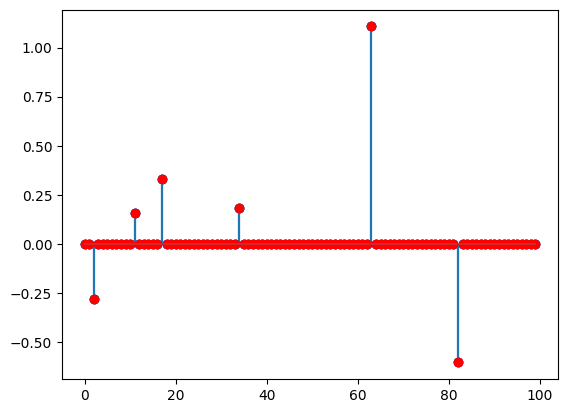

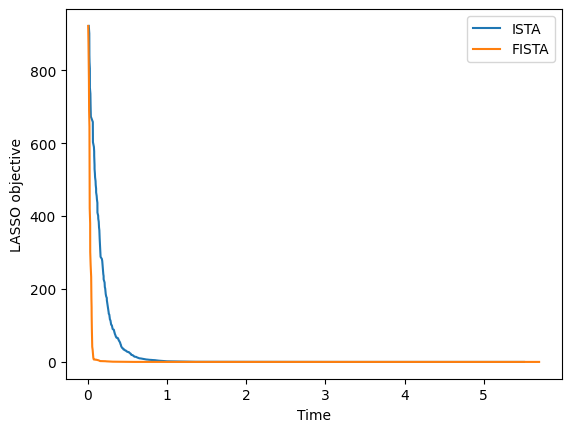

In [3]:
rng = np.random.RandomState(42)
m, n = 1000, 100
SNR=20
# random design
A = rng.randn(m, n)  # random design


nonzero_prob=0.1
lambdaa = 0.1  # regularization parameter
x0= np.random.choice([0, 1], size=(n,1), p=[1-nonzero_prob, nonzero_prob]) #sparse signal generation

scales=np.random.normal(0, 1, (n,1))
x0=np.multiply(scales,x0)
print('nonzero count',np.count_nonzero(x0))
b = np.dot(A, x0)
b=add_AWGN(b,SNR)

maxit = 3000
x_ista, LASSOobj_ista, times_ista,nmse_ista = ISTA(A, b, lambdaa, maxit,x0)

x_fista, LASSOobj_fista, times_fista,nmse_fista =FISTA(A, b, lambdaa, maxit,x0)

import matplotlib.pyplot as plt
plt.close('all')

plt.figure()
plt.stem(x0, markerfmt='go')
plt.stem(x_ista, markerfmt='bo')
plt.stem(x_fista, markerfmt='ro')

plt.figure()
plt.plot(times_ista, LASSOobj_ista, label='ISTA')
plt.plot(times_fista, LASSOobj_fista, label='FISTA')
plt.xlabel('Time')
plt.ylabel('LASSO objective')
plt.legend()


plt.show()